# Rain Forecasting Using CfC (Static Data)
José Ferreira and Rúben Antunes

## Import required libraries

In [1]:
# Library for operating system functionalities
import os
# Library for numerical operations
import numpy as np
# Library for data manipulation and analysis
import pandas as pd
# Library for interactive data visualization
import matplotlib.pyplot as plt
# Library for image processing and manipulation
from PIL import Image
# Library for reading and writing Excel files
from openpyxl import load_workbook
# Library for reading and writing JSON files
import json
# Library for date and time operations
from datetime import datetime, timedelta
# Library for data splitting
from sklearn.model_selection import StratifiedKFold
# Library for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Libraries for Deep Learning models
import tensorflow as tf
from tensorflow import keras
# Library for Liquid Neural Networks
from ncps.keras import CfC
from ncps.wirings import AutoNCP
# PSJ method module
import psj

## Set Constants and Hyperparameters

In [2]:
# Constants
DATASET_PATH = 'datasets/precipitation_dataset/'
DATASET_VALUES_PATH = DATASET_PATH + 'values/'
DATASET_IMAGES_PATH = DATASET_PATH + 'images/'
PRECIPITATION_CLASSES = ['Verde', 'Verde Claro', 'Amarelo']
STATIONS = {
    1200554: 'Faro',
    1200558: 'Evora',
    1200562: 'Beja',
    1200570: 'Castelo Branco',
    1200571: 'Portalegre',
    1200575: 'Braganca',
    1210683: 'Guarda',
    1210702: 'Aveiro',
    1210707: 'Coimbra',
    1210718: 'Leiria',
    1210734: 'Santarem',
    1210770: 'Setubal',
    1240566: 'Vila Real',
    1240610: 'Viana do Castelo',
    1240675: 'Viseu',
    1240903: 'Porto',
    6212124: 'Braga',
    7240919: 'Lisboa'
}
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 100, 100, 4 # Image = 100x100 RGBA
TIME_DIFFERENCE = 1 # Time difference between the image and the precipitation value in hours
SAMPLE_LIMIT = 20 # Limit of samples for each precipitation category (None = no limit)
IMAGE_REPLACEMENT_METHOD = None # Method to be used when an image doesn't exist (None = no replacement)

# Hyperparameters
REPRODUCIBILITY_SEED = 88 # Seed for reproducibility (None = no reproducibility)
LOAD_BEST_WEIGHTS = False # Don't load best weights when comparing weight initialization methods
WEIGHT_INITIALIZATION_METHOD = None # Method to initialize weights (default = glorot_uniform)
EPOCHS = 10 # Number of training epochs
FOLDS = 3 # Number of cross-validation folds
BATCH_SIZE = 5 # Batch size
HIDDEN_LAYERS = 1 # Number of hidden layers
HIDDEN_NEURONS = 64 # Number of neurons in each hidden layer

## Define auxiliary functions

In [3]:
def count_occurrences_of_each_value(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

def generate_replacement_image(image_datetime, station_id):
    match IMAGE_REPLACEMENT_METHOD:
        case 'copy_previous':
            new_image_datetime = image_datetime - timedelta(hours=1)
            new_image_date_string = image_datetime.strftime("%Y-%m-%d")
            new_image_datetime_string = new_image_datetime.strftime("%Y-%m-%dT%H%M")
            new_image_path = DATASET_IMAGES_PATH + str(station_id) + '/' + new_image_date_string + '/' + new_image_datetime_string + '.png'
            # If the image exist, open it
            if os.path.exists(new_image_path):
                return Image.open(new_image_path)
            # If the image doesn't exist, return None
            else:
                return None
        case 'copy_next':
            new_image_datetime = image_datetime + timedelta(hours=1)
            new_image_date_string = image_datetime.strftime("%Y-%m-%d")
            new_image_datetime_string = new_image_datetime.strftime("%Y-%m-%dT%H%M")
            new_image_path = DATASET_IMAGES_PATH + str(station_id) + '/' + new_image_date_string + '/' + new_image_datetime_string + '.png'
            # If the image exist, open it
            if os.path.exists(new_image_path):
                return Image.open(new_image_path)
            # If the image doesn't exist, return None
            else:
                return None
        case _:
            return None

def show_dataset_sample(images_array, labels_array):
    # Iterate over the precipitation classes
    for i, precipitation_class in enumerate(PRECIPITATION_CLASSES):
        # Find an example index for each precipitation class
        index = labels_array.tolist().index(i)

        # Plot the image
        plt.subplot(1, len(PRECIPITATION_CLASSES), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images_array[index])
        plt.xlabel(precipitation_class)

    # Show the figure
    plt.show()

## Data Treatment

Dataset sample:


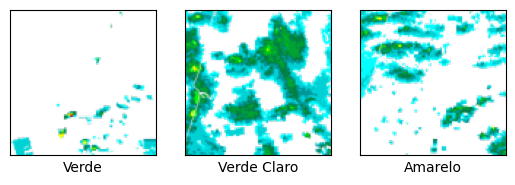

Number of samples of each class:
0: 20
1: 20
2: 17


In [4]:
# Initialize numpy and tensorflow seeds for reproducible results
np.random.seed(REPRODUCIBILITY_SEED)
tf.random.set_seed(REPRODUCIBILITY_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Initialize counter for samples of each precipitation category
counter_dictionary = {key: 0 for key in range(len(PRECIPITATION_CLASSES))}

# Initialize arrays to store precipitation values and images
precipitation_array = np.empty(0, dtype=int)
images_array = np.empty((0, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Shuffle stations IDs to avoid bias
stations_ids = list(STATIONS.keys())
np.random.shuffle(stations_ids)

# Iterate over the stations
for station_id in stations_ids:
    # Load the station JSON data
    station_json = DATASET_VALUES_PATH + str(station_id) + '.json'
    with open(station_json) as f:
        json_data = json.load(f)

    # Iterate over the precipitation values
    for date, hours in json_data.items():
        for hour in hours:
            precipitation_value = json_data[date][hour]

            # If there's a sample limit and the current precipitation value has already reached the limit, skip the current iteration
            if SAMPLE_LIMIT is not None and counter_dictionary[precipitation_value] == SAMPLE_LIMIT:
                continue

            # Get the image path
            precipitation_datetime_string = date + ' ' + hour
            precipitation_datetime = datetime.strptime(precipitation_datetime_string, "%Y-%m-%d %H:%M")
            image_datetime = precipitation_datetime - timedelta(hours=TIME_DIFFERENCE)
            image_date_string = image_datetime.strftime("%Y-%m-%d")
            image_datetime_string = image_datetime.strftime("%Y-%m-%dT%H%M")
            image_path = DATASET_IMAGES_PATH + str(station_id) + '/' + image_date_string + '/' + image_datetime_string + '.png'

            # If the image exist, open it
            if os.path.exists(image_path):
                image = Image.open(image_path)
            # If the image doesn't exist, generate a replacement image
            else:
                image = generate_replacement_image(image_datetime, station_id)
                # If there's no replacement image, break the current cycle
                if image is None:
                    break

            # Resize the image
            resized_image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))

            # Convert the image to an array
            image_array = np.array(resized_image)

            # Normalize pixel values to be between 0 and 1
            image_array = image_array / 255

            # Close the image
            image.close()

            # Add the precipitation value to the precipitation array
            precipitation_array = np.append(precipitation_array, precipitation_value)

            # Add the image to the images array
            images_array = np.append(images_array, [image_array], axis=0)

            # Increment the counter for the current precipitation value
            counter_dictionary[precipitation_value] += 1

# Visualize dataset sample
print("Dataset sample:")
show_dataset_sample(images_array, precipitation_array)

print("Number of samples of each class:")
for key, value in count_occurrences_of_each_value(precipitation_array).items():
    print(f"{key}: {value}")

## Model Initialization

In [5]:
# Reset all state generated by keras
keras.backend.clear_session()

# Initialize the model to allow weight initialization before actual training
base_model = keras.Sequential([
    keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
    keras.layers.Dropout(0.35),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ),
    keras.layers.Dropout(0.0035),
    keras.layers.Flatten(name='flatten')
])

# Print model summary
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,624 (260.25 KB)

 Trainable params: 66,240 (258.75 KB)

 Non-trainable params: 384 (1.50 KB)

## Weight Initialization

In [6]:
def get_weight_initializer():
    match WEIGHT_INITIALIZATION_METHOD:
        case 'psj':
            print("Method PSJ")
            psj_method = psj.PSJmethod(base_model, HIDDEN_NEURONS, IMAGE_HEIGHT * IMAGE_WIDTH, len(PRECIPITATION_CLASSES), images_array, precipitation_array)
            return tf.constant_initializer(psj_method), tf.constant_initializer(psj.iniL2(HIDDEN_NEURONS, HIDDEN_NEURONS)), keras.initializers.Ones()
        case 'glorot_normal':
            print("Method GlorotNormal")
            glorot_normal = keras.initializers.GlorotNormal(seed=REPRODUCIBILITY_SEED)
            return glorot_normal, glorot_normal, glorot_normal
        case 'glorot_uniform':
            print("Method GlorotUniform")
            glorot_uniform = keras.initializers.GlorotUniform(seed=REPRODUCIBILITY_SEED)
            return glorot_uniform, glorot_uniform, glorot_uniform
        case 'he_normal':
            print("Method HeNormal")
            he_normal = keras.initializers.HeNormal(seed=REPRODUCIBILITY_SEED)
            return he_normal, he_normal, he_normal
        case 'he_uniform':
            print("Method HeUniform")
            he_uniform = keras.initializers.HeUniform(seed=REPRODUCIBILITY_SEED)
            return he_uniform, he_uniform, he_uniform
        case 'lecun_normal':
            print("Method LecunNormal")
            lecun_normal = keras.initializers.LecunNormal(seed=REPRODUCIBILITY_SEED)
            return lecun_normal, lecun_normal, lecun_normal
        case 'lecun_uniform':
            print("Method LecunUniform")
            lecun_uniform = keras.initializers.LecunUniform(seed=REPRODUCIBILITY_SEED)
            return lecun_uniform, lecun_uniform, lecun_uniform
        case 'orthogonal':
            print("Method Orthogonal")
            orthogonal = keras.initializers.Orthogonal()
            return orthogonal, orthogonal, orthogonal
        case 'random_normal':
            print("Method RandomNormal")
            random_normal = keras.initializers.RandomNormal(mean=0., stddev=1.)
            return random_normal, random_normal, random_normal
        case 'random_uniform':
            print("Method RandomUniform")
            random_uniform = keras.initializers.RandomUniform(minval=0., maxval=1.)
            return random_uniform, random_uniform, random_uniform
        case 'identity':
            print("Method Identity")
            identity = keras.initializers.Identity()
            return identity, identity, identity
        case 'truncated_normal':
            print("Method TruncatedNormal")
            truncated_normal = keras.initializers.TruncatedNormal(mean=0., stddev=0.5)
            return truncated_normal, truncated_normal, truncated_normal
        case 'variance_scaling':
            print("Method VarianceScaling")
            variance_scaling = keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
            return variance_scaling, variance_scaling, variance_scaling
        case 'zeros':
            print("Method Zeros")
            zeros = keras.initializers.Zeros()
            return zeros, zeros, zeros
        case 'ones':
            print("Method Ones")
            ones = keras.initializers.Ones()
            return ones, ones, ones
        case _:
            print("No Method Selected, using default (GlorotUniform)")
            glorot_uniform = keras.initializers.GlorotUniform(seed=REPRODUCIBILITY_SEED)
            return glorot_uniform, glorot_uniform, glorot_uniform

# Create 3 initializers that will train the model
print("Weight initialization - Start")
initializer1, initializer2, initializer3 = get_weight_initializer()
print("Weight initialization - End")

Weight initialization - Start
No Method Selected, using default (GlorotUniform)
Weight initialization - End


## Model Training (CfC)


Fold 1/3

Epoch 1/10


C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5922 - f1_score: 0.5982 - loss: 6.2009 - precision: 0.7067 - recall: 0.5239
Epoch 1: val_accuracy improved from -inf to 0.63158, saving model to model_weights/cfc_static_data_time_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.6025 - f1_score: 0.6088 - loss: 6.1878 - precision: 0.7123 - recall: 0.5388 - val_accuracy: 0.6316 - val_f1_score: 0.5072 - val_loss: 8.4987 - val_precision: 0.6316 - val_recall: 0.6316
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6598 - f1_score: 0.5915 - loss: 3.7528 - precision: 0.6598 - recall: 0.6598
Epoch 2: val_accuracy did not improve from 0.63158
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6567 - f1_score: 0.5939 - loss: 3.8124 - precision: 0.6567 - recall: 0.6567 - val_accuracy: 0.5263 - val_f1_score: 0.5112 - val_loss: 2.8978 - val_precision: 0.5263 - val_recall: 0.5263
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7763 - f1_sco

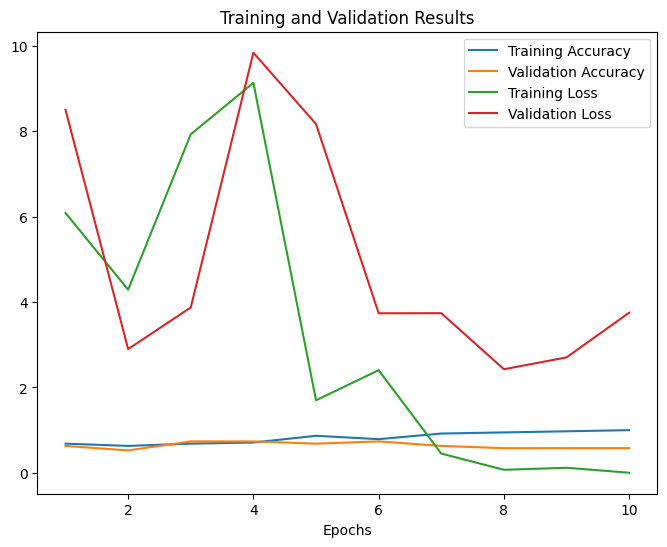

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


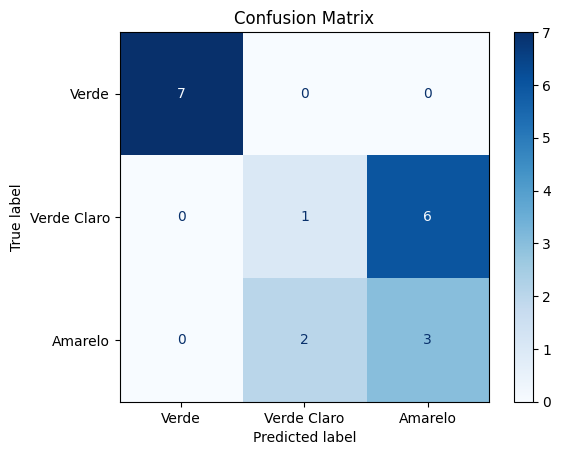


Fold 2/3

Epoch 1/10


C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4718 - f1_score: 0.3656 - loss: 4.9483 - precision: 0.4339 - recall: 0.3355
Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to model_weights/cfc_static_data_time_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.4720 - f1_score: 0.3697 - loss: 5.2290 - precision: 0.4396 - recall: 0.3450 - val_accuracy: 0.6842 - val_f1_score: 0.5556 - val_loss: 10.9098 - val_precision: 0.6842 - val_recall: 0.6842
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6626 - f1_score: 0.4716 - loss: 9.5872 - precision: 0.6626 - recall: 0.6626
Epoch 2: val_accuracy did not improve from 0.68421
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6650 - f1_score: 0.4800 - loss: 9.4640 - precision: 0.6650 - recall: 0.6650 - val_accuracy: 0.5263 - val_f1_score: 0.4000 - val_loss: 2.8523 - val_precision: 0.5263 - val_recall: 0.5263
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5922 - f1

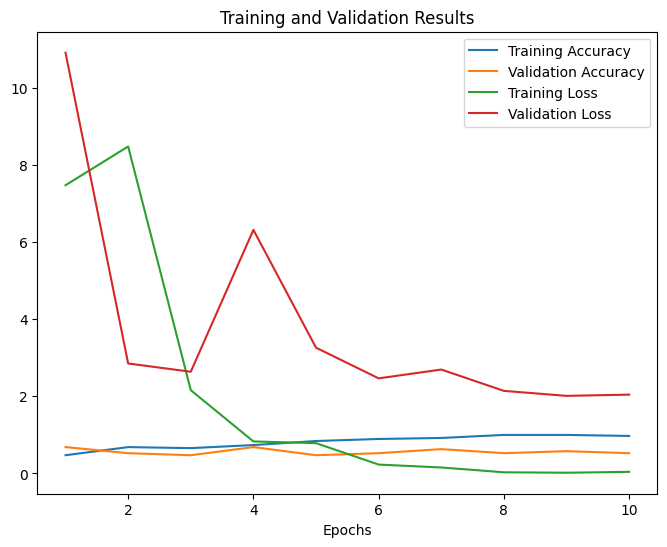

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


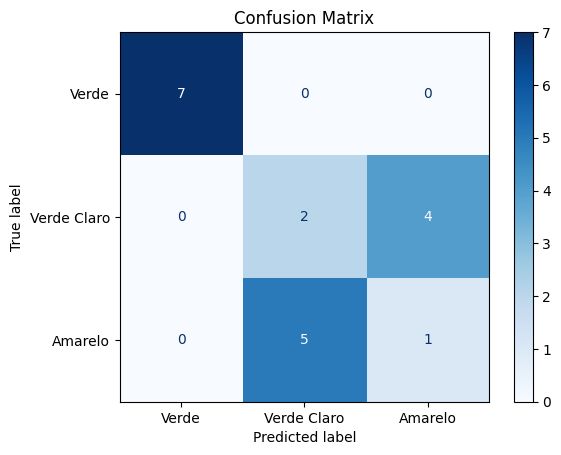


Fold 3/3

Epoch 1/10


C:\Users\antun\Desktop\UNI\PI\Experiments\Network-training-23-24\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3099 - f1_score: 0.2438 - loss: 12.6469 - precision: 0.3655 - recall: 0.3099
Epoch 1: val_accuracy improved from -inf to 0.68421, saving model to model_weights/cfc_static_data_time_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.3222 - f1_score: 0.2563 - loss: 12.7489 - precision: 0.3757 - recall: 0.3222 - val_accuracy: 0.6842 - val_f1_score: 0.5667 - val_loss: 11.9297 - val_precision: 0.6842 - val_recall: 0.6842
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7141 - f1_score: 0.5655 - loss: 17.4639 - precision: 0.7141 - recall: 0.7141
Epoch 2: val_accuracy did not improve from 0.68421
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7020 - f1_score: 0.5596 - loss: 17.4767 - precision: 0.7020 - recall: 0.7020 - val_accuracy: 0.4211 - val_f1_score: 0.3406 - val_loss: 18.8600 - val_precision: 0.4211 - val_recall: 0.4211
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5486 - f

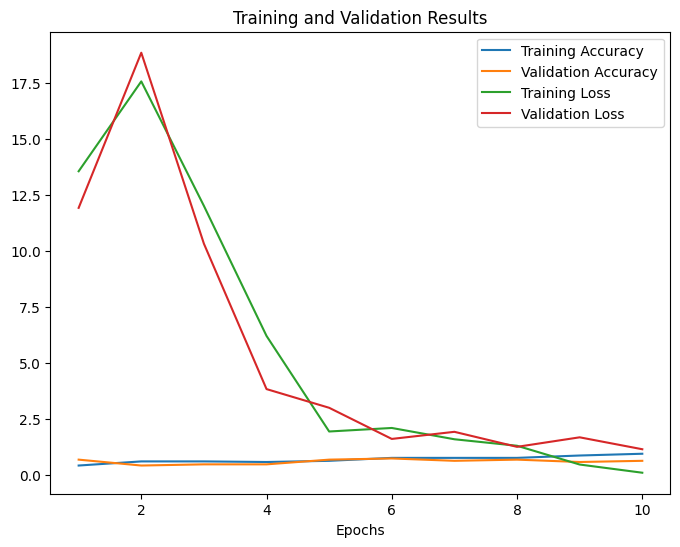

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


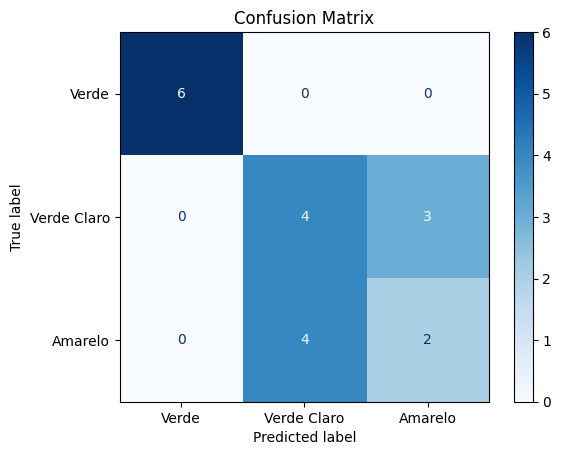


 --- Training completed --- 

model: CfC
time_difference: 1
sample_limit: 20
loaded_best_weights: False
weigh_initialization_method: None
hidden_layers: 1
hidden_neurons: 64
epochs: 10
folds: 3
batch_size: 5
accuracy: 0.9825
val_accuracy: 0.7193
loss: 0.0412
val_loss: 1.8624
precision: 0.9825
val_precision: 0.7193
recall: 0.9825
val_recall: 0.7193


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 40000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cf_c (CfC)                      │ (None, 3)              │     5,931,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,795,774 (67.89 MB)

 Trainable params: 5,931,924 (22.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,863,850 (45.26 MB)

In [7]:
# Initialize xls writer to store results
xlsFileName = 'results/CfC_Train_Static_Data_Method_' + str(WEIGHT_INITIALIZATION_METHOD) + '_HL' + str(HIDDEN_LAYERS) + '_N' + str(HIDDEN_NEURONS) + '_Folds' + str(FOLDS) + '_Epochs' + str(EPOCHS) + '_' + datetime.now().strftime("%Y_%m_%d_%H%M%S") + '.xlsx'
writer = pd.ExcelWriter(xlsFileName, engine='openpyxl')

# Initialize arrays to store results
accuracies = []
val_accuracies = []
losses = []
val_losses = []
precisions = []
val_precisions = []
recalls = []
val_recalls = []

try:
    # Stratified k-fold cross validation
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=REPRODUCIBILITY_SEED)
    for fold, (train_idx, val_idx) in enumerate(skf.split(images_array, precipitation_array)):
        print(f"\nFold {fold+1}/{FOLDS}\n")

        # Split the data
        train_images, val_images = images_array[train_idx], images_array[val_idx]
        train_labels, val_labels = precipitation_array[train_idx], precipitation_array[val_idx]

        # One-hot encode the labels
        train_labels_one_hot = keras.utils.to_categorical(train_labels, num_classes=len(PRECIPITATION_CLASSES))
        val_labels_one_hot = keras.utils.to_categorical(val_labels, num_classes=len(PRECIPITATION_CLASSES))

        # Reset all state generated by keras
        keras.backend.clear_session()

        # Rebuild model
        cfc_model = keras.Sequential([
            keras.layers.Input(shape=(100, 100, 4)),
            keras.layers.Reshape((1, 100 * 100 * 4)),
            CfC(AutoNCP(HIDDEN_NEURONS, output_size=len(PRECIPITATION_CLASSES))),
            keras.layers.Dense(len(PRECIPITATION_CLASSES), activation='softmax')
        ])

        # Compile model
        cfc_model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0055), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

        # Callback to save model weights
        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="model_weights/cfc_static_data_time_difference_" + str(TIME_DIFFERENCE) + ".weights.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max', save_weights_only=True)

        # Load best weights
        if LOAD_BEST_WEIGHTS:
            weights_path = 'model_weights/cfc_static_data_time_difference_' + str(TIME_DIFFERENCE) + '.weights.h5'
            try:
                cfc_model.load_weights(weights_path)
                print("Weights loaded")
            except:
                print("Weights not loaded")

        # Data augmentation
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.02,
            height_shift_range=0.02,
            shear_range=0.02,
            zoom_range=0,
            fill_mode='nearest'
        )

        # Train model
        history = cfc_model.fit(datagen.flow(train_images, train_labels_one_hot, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(val_images, val_labels_one_hot), callbacks=[model_checkpoint])

        # Show fold results
        epochs_range = range(1, EPOCHS + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
        plt.plot(epochs_range, history.history['loss'], label='Training Loss')
        plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Results')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()

        # Calculate confusion matrix
        predictions = cfc_model.predict(val_images)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(val_labels_one_hot, axis=1)
        cm = confusion_matrix(true_labels, predicted_labels)

        # Show confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=PRECIPITATION_CLASSES)
        disp.plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()

        # Store best results
        accuracies.append(max(history.history['accuracy']))
        val_accuracies.append(max(history.history['val_accuracy']))
        losses.append(min(history.history['loss']))
        val_losses.append(min(history.history['val_loss']))
        precisions.append(max(history.history['precision']))
        val_precisions.append(max(history.history['val_precision']))
        recalls.append(max(history.history['recall']))
        val_recalls.append(max(history.history['val_recall']))

        # Save fold results
        fold_results = {
            'epoch' : epochs_range,
            'accuracy': np.round(history.history['accuracy'], 4),
            'val_accuracy': np.round(history.history['val_accuracy'], 4),
            'loss' : np.round(history.history['loss'], 4),
            'val_loss' : np.round(history.history['val_loss'], 4),
            'precision': np.round(history.history['precision'], 4),
            'val_precision': np.round(history.history['val_precision'], 4),
            'recall': np.round(history.history['recall'], 4),
            'val_recall': np.round(history.history['val_recall'], 4)
        }
        df = pd.DataFrame(fold_results)
        sheet_name = f'Fold_{fold+1}_Results'
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Calculate and save average results
    final_results = {
        'model' : 'CfC',
        'time_difference' : TIME_DIFFERENCE,
        'sample_limit' : SAMPLE_LIMIT,
        'loaded_best_weights': str(LOAD_BEST_WEIGHTS),
        'weigh_initialization_method' : str(WEIGHT_INITIALIZATION_METHOD),
        'hidden_layers' : HIDDEN_LAYERS,
        'hidden_neurons' : HIDDEN_NEURONS,
        'epochs' : EPOCHS,
        'folds' : FOLDS,
        'batch_size' : BATCH_SIZE,
        'accuracy' : np.round(np.mean(accuracies), 4),
        'val_accuracy' : np.round(np.mean(val_accuracies), 4),
        'loss' : np.round(np.mean(losses), 4),
        'val_loss' : np.round(np.mean(val_losses), 4),
        'precision' : np.round(np.mean(precisions), 4),
        'val_precision' : np.round(np.mean(val_precisions), 4),
        'recall' : np.round(np.mean(recalls), 4),
        'val_recall' : np.round(np.mean(val_recalls), 4)
    }
    df = pd.DataFrame(final_results, index=[0])
    sheet_name = 'Folds_Average_Results'
    df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Show final results
    print('\n --- Training completed --- \n')
    for key, value in final_results.items():
        print(f"{key}: {value}")

    # Show model summary
    cfc_model.summary()
except KeyboardInterrupt:
    print('\n --- Training interrupted by user --- ')
finally:
    #Close the Writer
    writer.close()

    # Move last sheet to first position
    wb = load_workbook(xlsFileName)
    last_sheet_name = wb.sheetnames[-1]
    sheet_to_move = wb[last_sheet_name]
    wb.remove(sheet_to_move)
    wb._sheets = [sheet_to_move] + wb._sheets
    wb.save(xlsFileName)